<a href="https://colab.research.google.com/github/al34n1x/DataScience/blob/master/8.Machine_Learning/05_model_selection_with_gridsearchcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Selección de modelos con GridSearchCV

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



# Parameter selection, Validation, and Testing



Como vimos en la sesión anterior, muchos modelos tienen una serie de parámetros de configuración (llamados hiperparámetros) que influencian en el performance del modelo:

<img src=https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png>

En la figura de arriba vemos los resultados para una regresión en la que estamos ajustando los datos con modelos de grado 1, 4 y 15. Claramente vemos que el modelo de grado 1 tiene mucho bias y el de grado 15 mucha varianza (overfitting). El punto medio está en el polinomio de grado 4. 

¿Es posible ser capaces de encontrar una vía analítica que nos asegure cuantitativamente que un modelo está ajustado con los hiperparámetros óptimos? 

Si mostramos el grado de complejidad de un modelo comparado con su performance, veremos que existe un punto óptimo que nos indica que esos son los parámetros adecuados.



## Selección de Hiperparámetros, Over-fitting, y Under-fitting

Sin embargo, no existe una regla general que nos permita encontrar ese punto dulce salvo hacer pruebas por fuerza bruta. Es decir, para encontrar los valores óptimos de los hiperparámetros del modelo, es necesario hacer una búsqueda por fuerza bruta.

Por ejemplo, vamos a ver como sería una búsqueda de hiperparámetros en KNN:

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor

# generate toy dataset:

x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

cv = KFold(shuffle=True)

# for each parameter setting do cross-validation:

for n_neighbors in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20,30,40, 50]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.480363
n_neighbors: 2, average score: 0.681941
n_neighbors: 3, average score: 0.689136
n_neighbors: 4, average score: 0.728108
n_neighbors: 5, average score: 0.716960
n_neighbors: 6, average score: 0.738063
n_neighbors: 7, average score: 0.731266
n_neighbors: 8, average score: 0.769728
n_neighbors: 9, average score: 0.731850
n_neighbors: 10, average score: 0.748143
n_neighbors: 15, average score: 0.703793
n_neighbors: 20, average score: 0.635432
n_neighbors: 30, average score: 0.573888
n_neighbors: 40, average score: 0.625965
n_neighbors: 50, average score: 0.553663




En *scikit-learn* disponemos de una función que nos permite ver como evoluciona el poder predictivo de un modelo en función de la complejidad del mismo:

(0.0, 1.0)

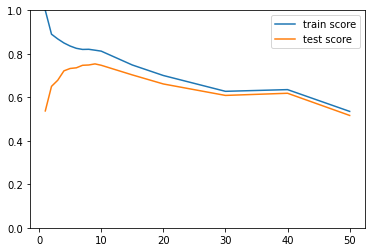

In [ ]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20,30,40, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.ylim=(0,1)
plt.plot(n_neighbors, train_scores.mean(axis=1), label="train score")
plt.plot(n_neighbors, test_scores.mean(axis=1), label="test score")
plt.legend(loc="best")
axes = plt.gca()
axes.set_ylim([0, 1])



Si el modelo requiere múltiples hiperparámetros, se prueban por fuerza bruta, todas las combinaciones. A continuación vamos a ver como lanzar una Support Vector Machine con los parámetros `C` (param. de regularización) y `gamma` (un parámetro del kernel gausiano de los SVMs)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:

for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.038816
C: 0.001000, gamma: 0.010000, average score: -0.111564
C: 0.001000, gamma: 0.100000, average score: -0.082767
C: 0.001000, gamma: 1.000000, average score: 0.003177
C: 0.010000, gamma: 0.001000, average score: -0.017392
C: 0.010000, gamma: 0.010000, average score: -0.103241
C: 0.010000, gamma: 0.100000, average score: 0.081746
C: 0.010000, gamma: 1.000000, average score: 0.077028
C: 0.100000, gamma: 0.001000, average score: -0.002883
C: 0.100000, gamma: 0.010000, average score: 0.165155
C: 0.100000, gamma: 0.100000, average score: 0.511996
C: 0.100000, gamma: 1.000000, average score: 0.487224
C: 1.000000, gamma: 0.001000, average score: 0.194883
C: 1.000000, gamma: 0.010000, average score: 0.606920
C: 1.000000, gamma: 0.100000, average score: 0.602279
C: 1.000000, gamma: 1.000000, average score: 0.718949
C: 10.000000, gamma: 0.001000, average score: 0.596283
C: 10.000000, gamma: 0.010000, average score: 0.595187
C: 10.000000, gamma:



Como este tipo de patrones es tan común, existe una clase en scikit-learn que nos permite realizar estas búsquedas de hiperparámetros. Este objeto se llama `GridSearchCV` y recibe como entrada un diccionario que describe todos los parámetros (y sus valores) que deben ser probados para el entrenamiento.


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv = KFold(shuffle=True)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3)



Una de las grandes ventajas de `GridSearchCV` es que es un *meta-estimador*. Es decir, toma como entrada un estimador de scikit-learn (SVM, LinearRegression, etc.) y crea un nuevo estimador con los parámetros ya ajustados. 
Como scikit-learn tiene una API muy uniforme, podemos utilizar el los métodos **`fit`**, **`predict`**, y **`score`** tal y como haríamos con cualquier otro estimador:

In [ ]:
grid.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.171, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.085, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.074, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.078, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.000, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ................ C=0.001, gamma=0.01, score=-0.167, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)



Internamente, ``fit`` hace algo más complicado de lo que hemos visto hasta ahora.

1. Primero realiza una cross-validación con los datos de entrada para encontrar la mejor combinación de parámetros.
2. Luego, una vez tiene los mejores parámetros, entrena un modelo con todos los datos de entrada (sin cross-validación) de manera que pueda devolver el mejor modelo ya entrenado.

Ahora vamos a ver las predicciones del modelo:

In [ ]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64



También es posible ver cual ha sido el mejor score y la combinación de parámetros que han llevado a él:

In [ ]:
print(grid.best_score_)

0.7534702100457242


In [ ]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


In [ ]:
print('Type:',type(grid.cv_results_))
print(grid.cv_results_.keys())

import pandas as pd
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

Type: <class 'dict'>
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000973,0.000265,0.000615,0.000265,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.171320,-0.084806,-0.074139,-0.077736,0.000333,-0.081533,0.054486,20
1,0.000800,0.000033,0.000484,0.000041,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.167183,-0.082868,-0.070755,-0.074558,0.003061,-0.078461,0.054058,19
2,0.000828,0.000036,0.000454,0.000014,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",-0.150825,-0.073923,-0.055993,-0.062619,0.015144,-0.065643,0.052827,16
3,0.000753,0.000013,0.000446,0.000015,0.001,1,"{'C': 0.001, 'gamma': 1}",-0.155365,-0.075191,-0.058146,-0.065916,0.013297,-0.068264,0.053656,17
4,0.000863,0.000058,0.000672,0.000288,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.166703,-0.082677,-0.070409,-0.074221,0.003335,-0.078135,0.053995,18


In [ ]:
cv_results_tiny = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
19,10,1,0.753470
15,1,1,0.707344
18,10,0.1,0.627820
14,1,0.1,0.625128
13,1,0.01,0.578478




Existe un problema de cara a utilizar este score de cara a evaluar el modelo. Este tipo de evaluaciones puede llevar al llamado error de evaluación de múltiples hipótesis (multiple hipothesis testing error). Este error ocurre cuando compararmos multiples configuraciones de parámetros. En este caso, algunos de ellos es posible que funcionen mejor por simple casualidad y, por tanto, el score obtenido no refleje como generaliza el modelo ante nuevos datos.

Por ello, se recomienda separar un test-set de los datos antes de realizar la gúsqueda en *grid*. Este patrón se llama training-validation-test split y es muy común en Machine Learning:



<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="75%">



Este patrón se consigue muy fácilmente:

1. Primero separamos los datos utilizando un ``train_test_split``
2. Luego entrenamos utilizando ``GridSearchCV`` sobre los datos de train del split
3. Filamente evaluamos utilizando el método ``score`` en el dataset de test del split.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3) 

grid.fit(X_train, y_train)
grid.score(X_test, y_test)  #Test Score

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.131, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.000, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.989, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.206, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-1.698, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.042, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=1, gamma=0.001, score=-0.076, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ................... C=1, gamma=0.001, score=-1.334, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.188, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.286, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.180, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.125, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.177, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


0.7262035177984737

In [ ]:
grid.best_score_ #CV Score

0.6702083258532943

In [ ]:
grid.score(X_train, y_train) #Train Score  

0.8172199836064503



Recordad que podemos ver los parámetros seleccionados:

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 1}



Existen Machine Learning scientists que utilizan un esquema más sencillo, separan el dataset en tres partes: training, validation, y test.
Esta alternativa es útil cuando tenemos gran cantidad de datos o cuando es inviable entrenar muchos modelos utilizando CV por que este entrenamiento nos llevaría demasiado tiempo. 

Esta aproximación se realiza en scikit-learn de la siguiente manera:

1. Realizamos una separación train-test
2. Luego aplicamos ``GridSearchCV`` con cross-validación ``ShuffleSplit`` de una sóla iteración.

<img src="https://raw.githubusercontent.com/al34n1x/DataScience/master/data/train_validation_test2.svg" width="75%">

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.057, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ................ C=0.001, gamma=0.01, score=-0.055, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ................. C=0.001, gamma=0.1, score=-0.045, total=   0.0s
[CV] C=0.001, gamma=1 ................................................
[CV] ................... C=0.001, gamma=1, score=-0.047, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................ C=0.01, gamma=0.001, score=-0.055, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ................. C=0.01, gamma=0.01, score=-0.035, total=   0.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


0.6776381048598354



Este método es mucho más rápido, pero puede llevar a peores hiperparámetros y, por lo tanto, peores resultados.

In [ ]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7262035177984737



# Ejercicio

- Utiliza Grid-search para entrenar un KNN con el mejor número de vecinos (p.ej. 1 - 50) en el dataset de Digits.

In [ ]:
#Respuesta